In [1]:
import numpy as np
import tqdm

import src

In [2]:
train_models = src.shapenet.get_shapenet_data("train")

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

class PPFNet:
    def make_model(self):
        inputs = keras.Input(shape=(None,None,10)) # (batch, patches, points_per_patches, ppf_features)
        x = inputs 
        
        #Patch pointNet
        for units in self.point_net_units[:-1]:
            x = keras.layers.Dense(units)(x)
            if self.use_batch_norm:
                x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation(keras.activations.relu)(x)
        x = keras.layers.Dense(self.point_net_units[-1])(x)
        x = tf.reduce_max(x, axis=-2)# (batch, patches, patche_features)
        local_features = x
        
        #Computing global features, nothing in the loop for orinigal implementation
        for i,units in enumerate(self.global_units):
            x = keras.layers.Dense(units)(x)
            if i != len(self.global_units) -1:
                if self.use_batch_norm:
                    x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation(keras.activations.relu)(x)            
        x = tf.reduce_max(x, axis=-2)# (batch, patches)
        
        #Combining features
        x = tf.repeat(x[...,tf.newaxis,:], tf.shape(local_features)[-2], axis=-2)
        x = tf.concat([local_features, x], axis=-1)
        
        #Computing combined features
        for units in self.mlp_units[:-1]: 
            x = keras.layers.Dense(units)(x)
            if self.use_batch_norm:
                x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation(keras.activations.relu)(x)
        x = keras.layers.Dense(self.point_net_units[-1])(x)
        
        return keras.models.Model(inputs, x)
    
    def __init__(self, 
                 point_net_units=[32,32,32], 
                 mlp_units=[64,64], 
                 global_units=[],
                 use_batch_norm=True,
                ):
        self.point_net_units = point_net_units
        self.mlp_units = mlp_units
        self.global_units = global_units
        self.use_batch_norm = use_batch_norm
        
        self.model = self.make_model()

In [4]:
nb_patches=2048

@tf.autograph.experimental.do_not_convert
def extract(path):
    cloud = src.shapenet.sample_points(path.decode("utf-8") , nb=100000)
    extractor = src.dataset.PPFPatchExtractor(nb_patches=nb_patches, nb_points=1024)
    #extractor = src.dataset.PPFPatchExtractor(nb_patches=512, nb_points=256)
    ppf, M = extractor.make_example(cloud)
    return ppf, M

def _map(path):
    y = tf.numpy_function(extract, [path], (tf.float32, tf.float32))
    return y
dataset = tf.data.Dataset.from_tensor_slices(train_models)
dataset = dataset.map(_map, num_parallel_calls=16)#Will do it in parrallel 
dataset = dataset.batch(4)
dataset = dataset.prefetch(4)

In [5]:
ppfnet = PPFNet()
optimizer = keras.optimizers.Adam(lr=0.01)
ppfnet.model.compile(optimizer=optimizer, loss=src.loss.N_tuple_loss(nb_patches))

In [20]:
ppfnet.model.fit(dataset)

 393/9204 [>.............................] - ETA: 3:44:11 - loss: 7.1728e-08

KeyboardInterrupt: 

In [ ]:
ppfnet.model.fit(dataset)

In [16]:
loss = []
for x,y in tqdm.tqdm(dataset):
    res = ppfnet.model.train_on_batch(x,y)
    loss.append(res)

  7%|▋         | 649/9204 [17:45<4:01:39,  1.69s/it]failed to load image
Traceback (most recent call last):
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/exchange/obj.py", line 324, in parse_mtl
    file_data = resolver.get(split[1])
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/resolvers.py", line 84, in get
    with open(os.path.join(self.parent, name.strip()), 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/leo/Documents/PPFNet-tensorflow/data/ShapeNetCore.v2/02691156/d583d6f23c590f3ec672ad25c77a396/models/../images/texture6.jpg'
 15%|█▌        | 1397/9204 [37:42<3:11:23,  1.47s/it]failed to load image
Traceback (most recent call last):
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/exchange/obj.py", line 324, in parse_mtl
    file_data = resolver.get(split[1])
  File "/home/leo/miniconda3/lib/python3.6/site-packages/trimesh/resolvers.py", line 84, in get
    with open(os.path.join(self.parent, name.s

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt

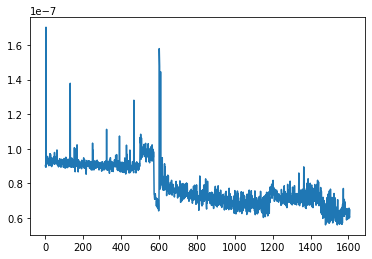

In [19]:
plt.plot(loss[500:])